In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU,LSTM
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout



import warnings
warnings.filterwarnings("ignore")

In [2]:
look_back= 1
neurons=[ 14 ,14 ]
n_epoch=1

In [3]:
df= pd.read_excel('WOPR.xlsx')
Time = df['Time']
df

,Time,WOPR
0,0.0000,0.000000
1,1.0000,4378.811500
2,4.0000,4379.608400
3,8.0000,4380.397000
4,16.5000,5691.611800
...,...,...
1019,3300.1875,9535.396706
1020,3302.9219,9513.793438
1021,3306.3398,9481.340067
1022,3309.1699,9451.805301


In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [5]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataset = np.insert(dataset,[0]*look_back,0)    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    dataY= np.array(dataY)        
    dataY = np.reshape(dataY,(dataY.shape[0],1))
    dataset = np.concatenate((dataX,dataY),axis=1)  
    return dataset


In [7]:
#  RMSPE
def RMSPE(x,y):
    result=0
    for i in range(len(x)):
        result += ((x[i]-y[i])/x[i])**2
    result /= len(x)
    result = sqrt(result)
    result *= 100
    return result

#  MAPE
def MAPE(x,y):
    result=0
    for i in range(len(x)):
        result += abs((x[i]-y[i])/x[i])
    result /= len(x)
    result *= 100
    return result

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1],1 )
    model = Sequential()
    model.add(LSTM(neurons[0], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(neurons[1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences=True))
    model.add(Dropout(0.5))
    
    model.add(Dense(3,'relu'))
   
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        print('epoch:',i+1)
        model.fit(X, y, epochs=10, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model
    
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [9]:
df.set_index("Time", inplace=True)
series=df

In [10]:
raw_values = series.values
# transform data to be stationary
diff = difference(raw_values, 1)
# create dataset x,y
dataset = diff.values
dataset = create_dataset(dataset,look_back)


In [11]:

# split into train and test sets
train_size = int(dataset.shape[0] * 0.8)
test_size = dataset.shape[0] - train_size
train, test = dataset[0:train_size], dataset[train_size:]


# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)



# fit the model
lstm_model = fit_lstm(train_scaled, 1, n_epoch, neurons)

epoch: 1
Epoch 1/10
818/818 [==============================] - 11s 8ms/step - loss: 0.0139
Epoch 2/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0134
Epoch 3/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138
Epoch 4/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138
Epoch 5/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138
Epoch 6/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0137
Epoch 7/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138
Epoch 8/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138
Epoch 9/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138
Epoch 10/10
818/818 [==============================] - 6s 7ms/step - loss: 0.0138


In [12]:
# forecast the entire training dataset to build up state for forecasting
predictions_train = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(raw_values)-i)
    # store forecast
    predictions_train.append(yhat)

In [13]:
# forecast the test data
predictions_test = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    #expected = raw_values[len(train) + i + 1]
   # print('Number%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

In [14]:

rmspe_test = RMSPE(raw_values[-len(test_scaled):],predictions_test)
print('Test RMSE: %.4f' % rmspe_test)
MAPE_test = MAPE(raw_values[-len(test_scaled):], predictions_test)
print('Test MAPE: %.5f' % MAPE_test)

predictions = np.concatenate((predictions_train,predictions_test),axis=0)

Test RMSE: 5.7844
Test MAPE: 2.22771


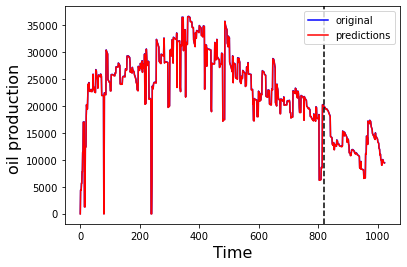

In [15]:
# line plot of observed vs predicted
fig, ax = plt.subplots(1)
ax.plot(raw_values, label='original', color='blue')
ax.plot(predictions, label='predictions', color='red')
ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
ax.legend(loc='upper right')
ax.set_xlabel('Time',fontsize = 16)
ax.set_ylabel('oil production ',fontsize = 16)
plt.show()
